## Test and compare trained models

In [1]:
# checkpoint file 
import glob 
base_dir = '/content/drive/My Drive/ColabNotebooks/MIMIC/TCN/VAE/checkpoints/'
workname = '0507_lr1e-4beta.001_res_regrtheta_5_mlp_regr_nonsens_21/'
all_path = glob.glob(base_dir+workname + '*.pt')
all_path = [p for p in all_path if "stage2" not in p]

In [2]:
import json 
with open(base_dir+workname+'params.json') as f: 
    params = json.load(f)
params['platform'] = 'colab'
class Args:
    def __init__(self, d=None):
        if d is not None:
            for key, value in d.items():
                setattr(self, key, value)
args = Args(params)

In [18]:
all_path

['/content/drive/My Drive/ColabNotebooks/MIMIC/TCN/VAE/checkpoints/0507_lr1e-4beta.001_res_regrtheta_5_mlp_regr_nonsens_21/stage1_fold_0_epoch101.pt',
 '/content/drive/My Drive/ColabNotebooks/MIMIC/TCN/VAE/checkpoints/0507_lr1e-4beta.001_res_regrtheta_5_mlp_regr_nonsens_21/stage1_sofa_fold_0_epoch101.pt',
 '/content/drive/My Drive/ColabNotebooks/MIMIC/TCN/VAE/checkpoints/0507_lr1e-4beta.001_res_regrtheta_5_mlp_regr_nonsens_21/stage1_clf_fold_0_epoch101.pt',
 '/content/drive/My Drive/ColabNotebooks/MIMIC/TCN/VAE/checkpoints/0507_lr1e-4beta.001_res_regrtheta_5_mlp_regr_nonsens_21/stage1_epoch101.pt',
 '/content/drive/My Drive/ColabNotebooks/MIMIC/TCN/VAE/checkpoints/0507_lr1e-4beta.001_res_regrtheta_5_mlp_regr_nonsens_21/stage1_clf_fold_1_epoch40.pt',
 '/content/drive/My Drive/ColabNotebooks/MIMIC/TCN/VAE/checkpoints/0507_lr1e-4beta.001_res_regrtheta_5_mlp_regr_nonsens_21/stage1_epoch40.pt',
 '/content/drive/My Drive/ColabNotebooks/MIMIC/TCN/VAE/checkpoints/0507_lr1e-4beta.001_res_regrth

In [3]:
import argparse
import os 
import copy 
import pickle
import numpy as np
import pandas as pd
import torch
import utils
from utils import AverageMeterSet
import prepare_data
import models
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=False)
from datetime import date
today = date.today()
date = today.strftime("%m%d")
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams["figure.dpi"] = 300
plt.style.use('bmh')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
legend_properties = {'weight':'bold', 'size': 14}
dir_data = {'satori': '/nobackup/users/weiliao', 'colab':'/content/drive/MyDrive/ColabNotebooks/MIMIC/Extract/MEEP/Extracted_sep_2022/0910'}


if __name__ == "__main__":

    parser = argparse.ArgumentParser(description="Parser for time series VAE models")
    parser.add_argument("--device_id", type=int, default=0, help="GPU id")
    parser.add_argument("--platform", type=str, default='colab', choices=['satori', 'colab'], help='Platform to run the code')
    # data/loss parameters
    parser.add_argument("--use_sepsis3", action = 'store_false', default= True, help="Whethe only use sepsis3 subset")
    parser.add_argument("--bucket_size", type=int, default=300, help="bucket size to group different length of time-series data")
    parser.add_argument("--beta", type=float, default=0.001, help="coefficent for the elbo loss")
    parser.add_argument("--gamma", type=float, default=0.5, help="coefficent for the total_corr loss")
    parser.add_argument("--alpha", type=float, default=0.5, help="coefficent for the clf loss")
    parser.add_argument("--theta", type=float, default=5, help="coefficent for the sofa loss in stage 1")
    parser.add_argument("--zdim", type=int, default=20, help="dimension of the latent space")
    parser.add_argument("--sens_ind", type=int, default=21, help="index of the sensitive feature")
    parser.add_argument("--scale_elbo", action = 'store_true', default=False, help="Whether to scale the ELBO loss")
    # model parameters
    parser.add_argument("--kernel_size", type=int, default=3, help="kernel size")
    parser.add_argument("--drop_out", type=float, default=0.2, help="drop out rate")
    parser.add_argument("--enc_channels", default=[256, 128, 64, 40],  help="number of channels in the encoder")
    parser.add_argument("--dec_channels", default = [64, 128, 256, 200], help="number of channels in the decoder")
    parser.add_argument("--num_inputs", type=int, default=200, help="number of features in the inputs")
    # discriminator parameters
    parser.add_argument("--disc_channels",  type=int, default=200, help="number of channels in the discriminator")
    # regressor parameters
    parser.add_argument("--regr_model",  type=str, default='mlp', choices=['mlp', 'tcn'], help='Model choice in sofa prediction')
    parser.add_argument("--regr_channels",  type=int, default=200, help="number of channels in the regressor")
    parser.add_argument("--regr_tcn_channels",  nargs='+', type=int, help="number of channels in the regressor")
    parser.add_argument("--regr_only_nonsens", action = 'store_false', default=True, help="Whether only using nonsens latents to predict sofa")
    # training parameters
    parser.add_argument("--epochs", type=int, default=300, help="Number of training epochs")
    parser.add_argument("--data_batching", type=str, default='close', choices=['same', 'close', 'random'], help='How to batch data')
    parser.add_argument("--bs", type=int, default=16, help="batch size")
    parser.add_argument("--lr", type=float, default=1e-4, help="Learning rate")
    parser.add_argument("--patience", type=int, default=20, help="Patience epochs for early stopping.")
    parser.add_argument("--checkpoint", type=str, default='test', help=" name of checkpoint model")

    # args = parser.parse_known_args()[0]
    device = torch.device("cuda:%d"%args.device_id if torch.cuda.is_available() else "cpu")
    arg_dict = vars(args)
    # workname = date + "_" +  args.checkpoint
    # utils.creat_checkpoint_folder('/home/weiliao/FR-TSVAE/checkpoints/' + workname, 'params.json', arg_dict)

    # load data
    meep_mimic = np.load(dir_data[args.platform] + '/MIMIC_compile_0911_2022.npy', \
                    allow_pickle=True).item()
    train_vital = meep_mimic ['train_head']
    dev_vital = meep_mimic ['dev_head']
    test_vital = meep_mimic ['test_head']
    mimic_static = np.load(dir_data[args.platform] + '/MIMIC_static_0922_2022.npy', \
                            allow_pickle=True).item()
    mimic_target = np.load(dir_data[args.platform] + '/MIMIC_target_0922_2022.npy', \
                            allow_pickle=True).item()
        
    train_head, train_static, train_sofa, train_id =  utils.crop_data_target('mimic', train_vital, mimic_target, mimic_static, 'train', args.sens_ind)
    dev_head, dev_static, dev_sofa, dev_id =  utils.crop_data_target('mimic', dev_vital , mimic_target, mimic_static, 'dev',  args.sens_ind)
    test_head, test_static, test_sofa, test_id =  utils.crop_data_target('mimic', test_vital, mimic_target, mimic_static, 'test',  args.sens_ind)

    if args.use_sepsis3 == True:
        train_head, train_static, train_sofa, train_id = utils.filter_sepsis('mimic', train_head, train_static, train_sofa, train_id, args.platform)
        dev_head, dev_static, dev_sofa, dev_id = utils.filter_sepsis('mimic', dev_head, dev_static, dev_sofa, dev_id, args.platform)
        test_head, test_static, test_sofa, test_id = utils.filter_sepsis('mimic', test_head, test_static, test_sofa, test_id, args.platform)

    # build model
    model = models.Ffvae(args)
    # torch.save(model.state_dict(), '/home/weiliao/FR-TSVAE/start_weights.pt')

    # 10-fold cross validation
    trainval_head = train_head + dev_head
    trainval_static = train_static + dev_static
    trainval_stail = train_sofa + dev_sofa
    trainval_ids = train_id + dev_id

    # prepare data
    torch.autograd.set_detect_anomaly(True)
    for c_fold, (train_index, test_index) in enumerate(kf.split(trainval_head)):
        # best_loss = 1e4
        # patience = 0
        # if c_fold >= 1:
        #     model.load_state_dict(torch.load('/home/weiliao/FR-TSVAE/start_weights.pt'))
        print('Starting Fold %d' % c_fold)
        print("TRAIN:", len(train_index), "TEST:", len(test_index))
        train_head, val_head = utils.slice_data(trainval_head, train_index), utils.slice_data(trainval_head, test_index)
        train_static, val_static = utils.slice_data(trainval_static, train_index), utils.slice_data(trainval_static, test_index)
        train_stail, val_stail = utils.slice_data(trainval_stail, train_index), utils.slice_data(trainval_stail, test_index)
        train_id, val_id = utils.slice_data(trainval_ids, train_index), utils.slice_data(trainval_ids, test_index)

        train_dataloader, dev_dataloader, test_dataloader = prepare_data.get_data_loader(args, train_head, val_head,
                                                                                            test_head, 
                                                                                            train_stail, val_stail,
                                                                                            test_sofa,
                                                                                            train_static=train_static,
                                                                                            dev_static=val_static,
                                                                                            test_static=test_static,
                                                                                            train_id=train_id,
                                                                                            dev_id=val_id,
                                                                                            test_id=test_id)

Starting Fold 0
TRAIN: 8964 TEST: 2242
8964
Starting Fold 1
TRAIN: 8965 TEST: 2241
8965
Starting Fold 2
TRAIN: 8965 TEST: 2241
8965
Starting Fold 3
TRAIN: 8965 TEST: 2241
8965
Starting Fold 4
TRAIN: 8965 TEST: 2241
8965


In [ ]:
# deal with CM and AUC plots
import sklearn.metrics as metrics
import seaborn as sns 
import torch.nn as nn 

for p in all_path: 
    model.load_state_dict(torch.load(p))
    print(p)
    #  test on test loader 
    model.eval()
    logits = []
    stt = []
    with torch.no_grad():
        for vitals, static, target, train_ids, key_mask in test_dataloader:
            # (bs, feature_dim, T)
            vitals = vitals.to(device)
            # (bs)
            static = static.to(device)
            # (bs, T, 1)
            target = target.to(device)
            # (bs, T)
            key_mask = key_mask.to(device)

            # _mu shape [bs, zdim, T]
            _mu, _logvar = model.encoder(vitals)
            # b_logits [bs, 1]
            b_logits = _mu[:, model.sens_idx]
            logits.extend(torch.stack([b_logits[i].squeeze(0).mean() for i in range(len(b_logits))]))
            stt.extend(static)
    logits = torch.stack(logits)
    stt = torch.stack(stt) 
    metrics.RocCurveDisplay.from_predictions(stt.cpu(),  nn.Sigmoid()(logits).cpu())  
    plt.show()
    wname = p.split('/')[-1].split('.')[0]
    # plt.savefig('./checkpoints/' + workname + 'auc_curve/' + '%s_auc.eps'%wname, format='eps', bbox_inches = 'tight', pad_inches = 0.1, dpi=1200)

    pred =  (nn.Sigmoid()(logits).cpu() > 0.5).float()
    cm = metrics.confusion_matrix(stt.cpu(), pred)
    cf_matrix = cm/np.repeat(np.expand_dims(np.sum(cm, axis=1), axis=-1), 2, axis=1)
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    # percentage based on true label 
    gr = (cm/np.repeat(np.expand_dims(np.sum(cm, axis=1), axis=-1), 2, axis=1)).flatten()
    group_percentages = ['{0:.2%}'.format(value) for value in gr]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, group_counts)]

    labels = np.asarray(labels).reshape(2, 2)


    xlabel = ['Pred-%d'%i for i in range(2)]
    ylabel = ['%d'%i for i in range(2)]

    sns.set(font_scale = 1.5)

    hm = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap = 'OrRd', \
    annot_kws={"fontsize": 16}, xticklabels=xlabel, yticklabels=ylabel, cbar=False)
    # hm.set(title=title)
    fig = plt.gcf()
    plt.show()  
    # plt.savefig('./checkpoints/' + workname + 'cm_matrix/' + '%s_cm.eps'%wname, format='eps', bbox_inches = 'tight', pad_inches = 0.1, dpi=1200)

In [ ]:
# SOFA Test set results

In [44]:
# analyze on 20 paticular patients,
id_20 = np.random.choice(range(len(test_id)), size=20, replace=False)
model.load_state_dict(torch.load(all_path[1]))
id = test_id[id_20[0]]
sofa = mimic_target['test'][id]
_mu, _logvar = model.encoder(torch.FloatTensor(test_head[id_20[0]]).unsqueeze(0).to(device))
mu = _mu[:, model.nonsens_idx, :]
sofa_p = model.regr(mu.transpose(1, 2), "classify").squeeze(0).cpu().detach().numpy()

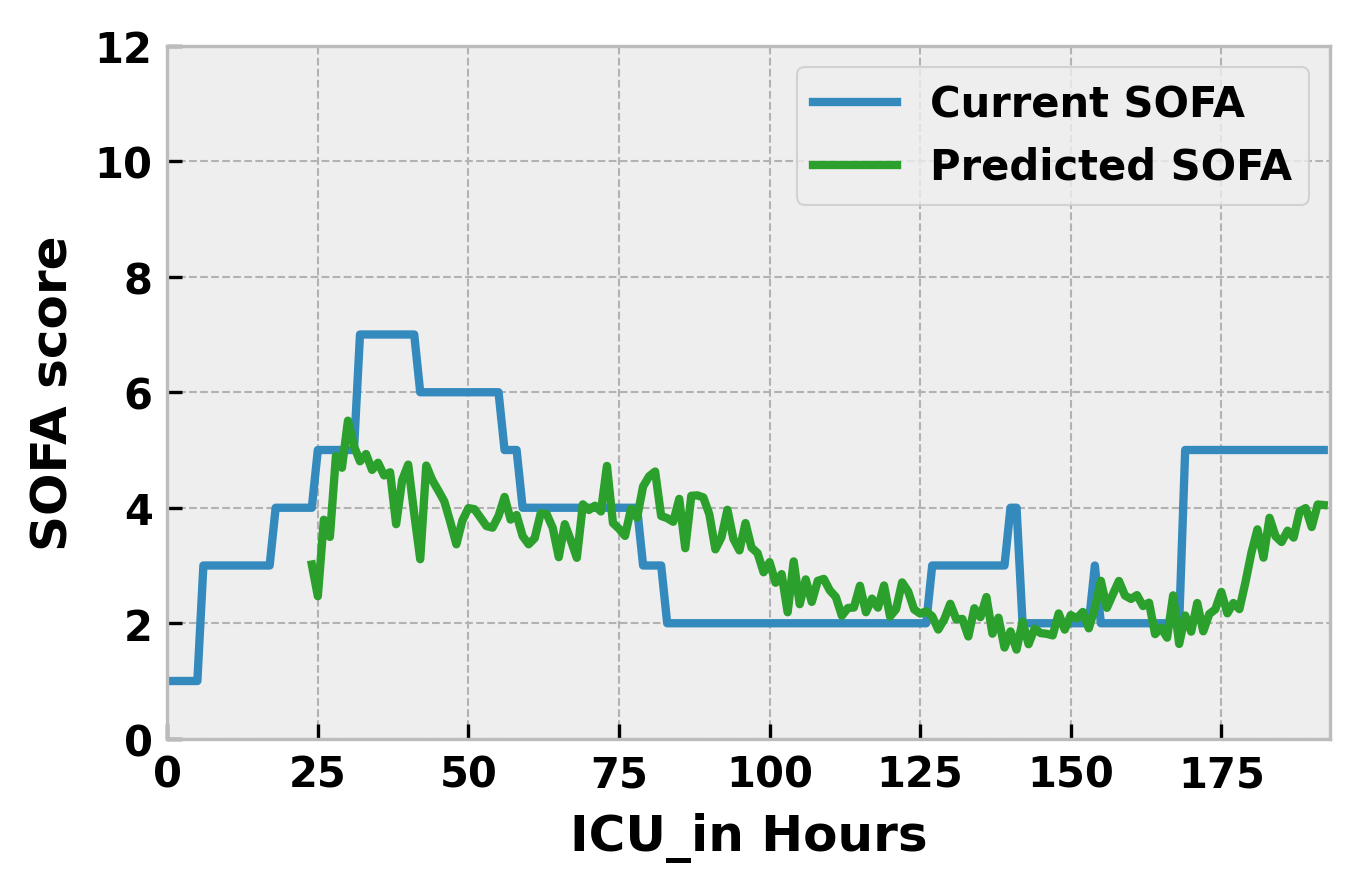

In [45]:

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
n = len(sofa)
ax.plot(range(len(sofa)), sofa, label='Current SOFA')
ax.plot(range(24, n), sofa_p*15, c="tab:green", label ='Predicted SOFA')
ax.set_xlim((0, len(sofa)))
ax.set_ylim((0, 12))
ax.set_ylabel('SOFA score', size=12,  fontweight='bold')
ax.set_xlabel('ICU_in Hours', size=12,  fontweight='bold')
legend_properties = {'weight':'bold'}
ax.legend(loc='upper right',  prop=legend_properties)

In [ ]:
, including MSE, MSE variation by ICU stay length 


In [ ]:
# Compare the same with second stage SOFA training 